<a href="https://colab.research.google.com/github/wsh32/machine_learning/blob/main/modules/04/2021f_Estimating_Face_Pose_from_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating Head Pose from Images

Back in 2004, a French grad student spent months taking photos of people's faces at different positions (tilted up/down or left/right). Interestingly, we can train an algorithm to detect face positoins from these photographs. Let's celebrate the difficult and tedious work of that student by using their dataset! 

First, check out [how the data were collected](https://web.archive.org/web/20190716041053/http://www-prima.inrialpes.fr/perso/Gourier/Faces/HPDatabase.html).

In [1]:
# Let's download the data (or upload if using colab). 
# You may need to click yes to approve running this code if using colab... Can we be trusted?

!wget "https://www.dropbox.com/s/9u9znk0utfr7yjf/HeadPoseImageDatabase.tar.gz?dl=0" -O head_pose.tar.gz
!tar -xvzf head_pose.tar.gz > /dev/null
#old: !wget "https://drive.google.com/uc?authuser=0&id=1304LwlF0o_L0N3njQyB1Gy77FGwUGIUg&export=download" -O head_pose.tar.gz

--2021-09-19 21:25:31--  https://www.dropbox.com/s/9u9znk0utfr7yjf/HeadPoseImageDatabase.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9u9znk0utfr7yjf/HeadPoseImageDatabase.tar.gz [following]
--2021-09-19 21:25:31--  https://www.dropbox.com/s/raw/9u9znk0utfr7yjf/HeadPoseImageDatabase.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc14c4fd236c0ac20a0367c17b8f.dl.dropboxusercontent.com/cd/0/inline/BWfte49XrxW6w6xkG5JmeTCSLxZ-GPxDnLE9GamGgqS8pu5W8eQQedzWLhY71JU0A38-CHAF9vdvOD5bs8fP42Mt70ctOMo9QIvk1dd61lxnEaIRpfLyimtjAz6_AEJpbYipZ9jqZHheOMBeA4FFE4Nr/file# [following]
--2021-09-19 21:25:32--  https://uc14c4fd236c0ac20a0367c17b8f.dl.dropboxusercontent.com/cd/0/inline/BWfte49XrxW6w6xkG5JmeTCSLxZ-GPxDnLE9G

## Load the data

These data comprise multiple people, each photographed at various head positions (both pitch and yaw).

The following code loads the images, crops to the face (face boxes provided in the dataset), and downsamples to 20x20 pixels.

In [2]:
import cv2
import os
import re
import numpy as np
import glob

def load_data():
    """ Load the head pose image dataset from here:
        http://www-prima.inrialpes.fr/perso/Gourier/Faces/HPDatabase.html
        The above website is no longer in commission, but it can be found here:
        https://web.archive.org/web/20190716041053/http://www-prima.inrialpes.fr/perso/Gourier/Faces/HPDatabase.html
        
        returns a tuple containing
            person_id: a list of subject directories where the image came from
            images: the face boxes cropped to (20, 20) grayscale pixels
            head pitch: the pitch of the subject's head
            yaw: the yaw of the subject's head 
            
        This version skips pitches more extreme than 30 and skips yaws of 0    """
    person_ids = []
    images = []
    pitches = []
    yaws = []
    for person_path in glob.glob('Person*'):
        for image_path in glob.glob(os.path.join(person_path, '*.jpg')):
            m = re.search('([-\+][0-9]*)([-\+][0-9]*).jpg$', image_path)
            pitch = float(m.group(1))
            yaw = float(m.group(2))

            # don't use images with extreme pitches
            if np.abs(pitch) > 30:
                continue
            # Also remove yaws == 0 to make logistic easier
            if yaw == 0:
              continue
            im = cv2.imread(image_path)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            face_box_path = os.path.join(image_path[:-4] + '.txt')
            with open(face_box_path) as f:
                lines = f.readlines()
                # grab the center pixel coordinate of the face (x_c, y_c) and
                # size (w, h) of the face bounding box
                x_c, y_c, w, h = (int(l) for l in lines[3:])
                # use a square cropping by taking the maximum of the two sizes
                big_length = max(w, h)

                # grab the face by indexing into the numpy array
                face_pixels = im[y_c-big_length//2:y_c+big_length//2,\
                                 x_c-big_length//2:x_c+big_length//2]
                try:
                    # resize the image to a (20, 20) patch to make it easier
                    # for linear regression (less dimensions)
                    face_pixels = cv2.resize(face_pixels, (20, 20))
                    images.append(face_pixels)
                    pitches.append(pitch)
                    yaws.append(yaw)
                    #print(person_path, yaw, pitch) #uncomment this to troubleshoot
                    person_ids.append(person_path)
                except Exception as ex:
                    continue
    return person_ids, np.array(images), np.array(pitches), np.array(yaws)

person_ids, images, pitches, yaws = load_data()

## Visualize the data
An important first step in any project is to visualize your data. You want to make sure everything is arranged as expected. The code below plots multiple head positions for the first three people. You can alter this code to look at other examples. 

We have excluded the examples with the yaw = 0 (looking straight ahead) to make some later exercises more straightforward.

**Discuss: What do you notice about the images?**


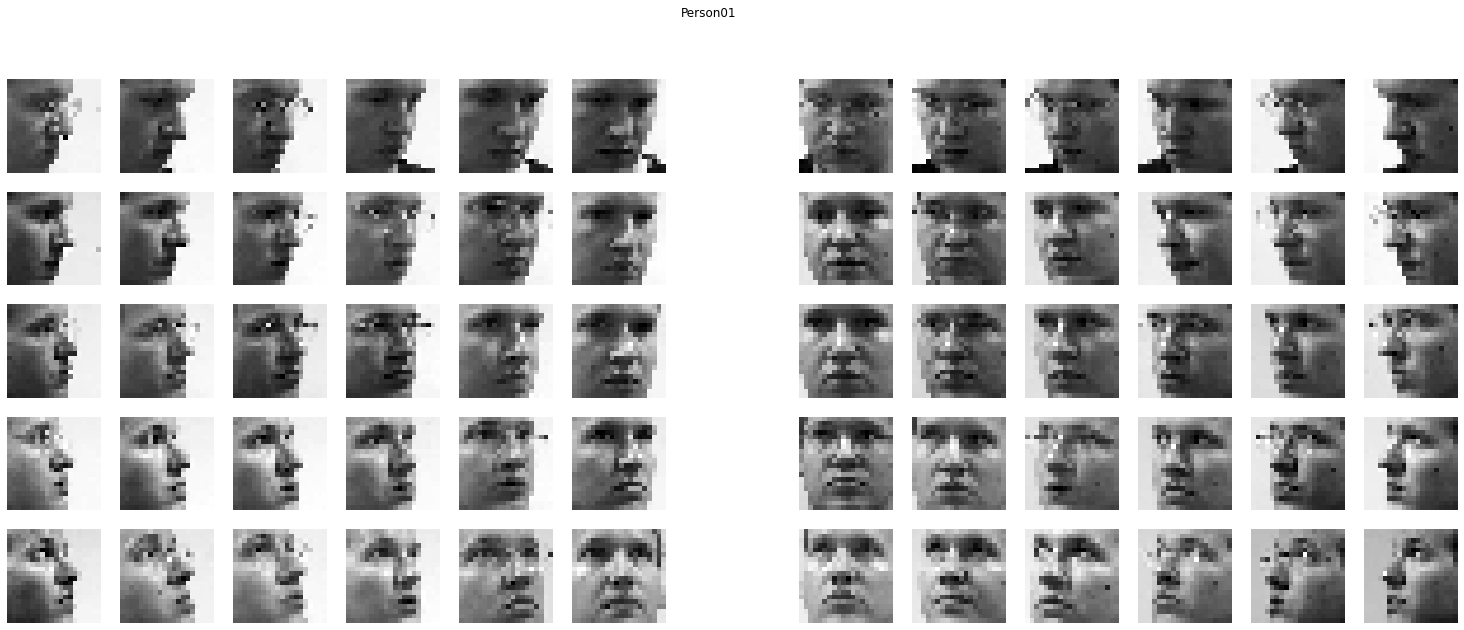

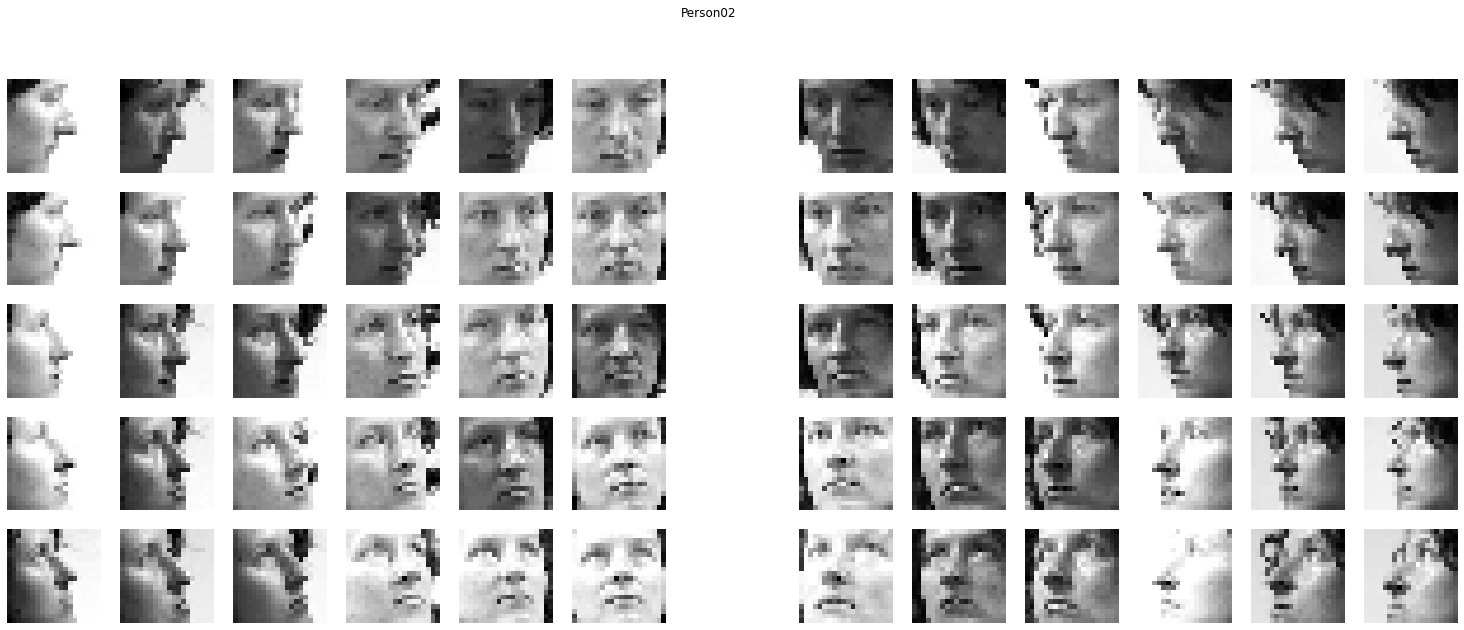

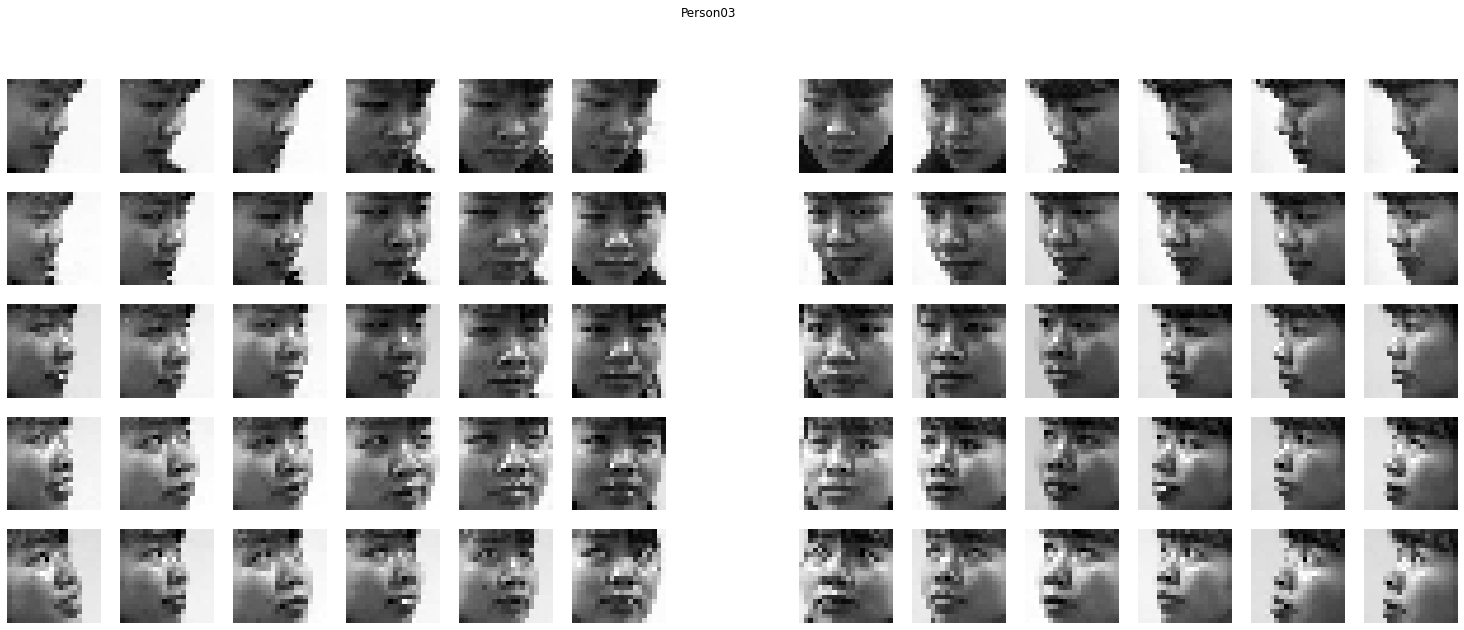

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_person(person_id):
    fig_scale = 2
    fig, ax = plt.subplots(5, 13, figsize=(13*fig_scale, 5*fig_scale))
    plt.suptitle(person_id)
    subplot_idx = 0
    for pitch in np.linspace(-30, 30, 5):
        for yaw in np.linspace(-90, 90, 13):
            subplot_idx += 1
            ax = plt.subplot(5, 13, subplot_idx)
            img_idx = np.argwhere(np.logical_and([p == person_id for p in person_ids], np.logical_and(pitches == pitch, yaws == yaw)))
            if img_idx.size:
                plt.set_cmap('gray')
                ax.imshow(images[img_idx[0]].squeeze(), interpolation='none')
            ax.set_axis_off()
    plt.show()

visualize_person('Person01')
visualize_person('Person02')
visualize_person('Person03')

## Perform train/test split by group
As you observed above, this dataset contains multiple images of the same people looking at different angles. We are now going to do a train/test split. In fact, we're doing a different kind of train/test split. This one will be by group instead of just randomly dividing up the images. This way images from a particular person are only in the training or only in the testing data (but not both). 

**Discuss: Why might we opt to split by group instead of randomly across all images?**


**Discuss: What is point of the line that starts with " `X = np.hstack(` ..."?**


In [4]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=.25, n_splits=1, random_state = 7)
indices = np.arange(len(yaws)) 

for train_idx, test_idx in gss.split(indices, groups=person_ids):
#  print("TRAIN:", train_idx, "TEST:", test_idx)
  print("TRAIN:", np.unique(np.array(person_ids)[train_idx]), "TEST:", np.unique(np.array(person_ids)[test_idx]))

# Reshape the images so each is represented by a vector of pixel values
X = images.reshape((images.shape[0], images.shape[1]*images.shape[2]))
num_pixels = len(X[0]) # num pixels

X = np.hstack((X, np.ones((X.shape[0],1))))

# Split the data into train and test based on indices
X_train = X[train_idx,:]
X_test = X[test_idx,:]
person_ids_train = np.array(person_ids)[train_idx]
person_ids_test = np.array(person_ids)[test_idx]
pitches_train = pitches[train_idx]
pitches_test = pitches[test_idx]
yaws_train = yaws[train_idx]
yaws_test = yaws[test_idx]

TRAIN: ['Person01' 'Person02' 'Person04' 'Person05' 'Person07' 'Person08'
 'Person10' 'Person12' 'Person13' 'Person14' 'Person15'] TEST: ['Person03' 'Person06' 'Person09' 'Person11']


## Build a model
Read and run the code below.

**Discuss: What equation does "w = ..." represent?**

**Discuss: Do you see any visual pattern in the weights (first plot)?**

**Discuss: What should the y-axes label be on the last plot?**


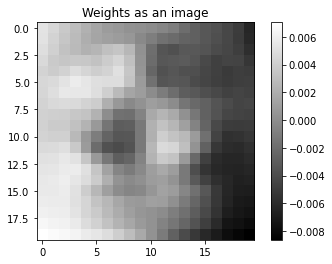

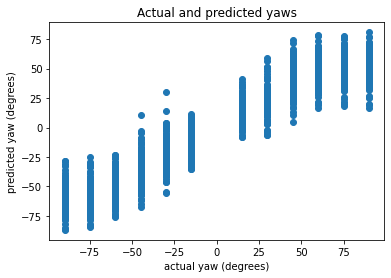

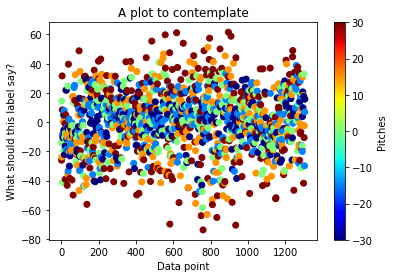

In [5]:
w = np.linalg.inv(X_train.T.dot(X_train) + 100000000*np.eye(num_pixels+1)).dot(X_train.T.dot(yaws_train))


# Plot the weights
plt.imshow(w[:-1].reshape((20, 20)))
plt.title('Weights as an image')
plt.colorbar()
plt.show()


# Plot the actual and predicted yaws
plt.scatter(yaws_train, X_train.dot(w))
plt.title('Actual and predicted yaws')
plt.xlabel('actual yaw (degrees)')
plt.ylabel('predicted yaw (degrees)')
plt.show()

# Make another plot!
plt.scatter(np.arange(len(yaws_train)),X_train.dot(w)-yaws_train,c=pitches_train,cmap="jet")
plt.title('A plot to contemplate')
plt.xlabel('Data point')
plt.ylabel('What should this label say?')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Pitches')
plt.show()

In the code above, we combined our data across all pitches (looking up vs straight ahead vs down). 

Now, let's only consider that data in which the pitch = 0 (looking straight ahead). 

**Discuss: Why might we opt to do this?**



## Analyze when looking straight ahead (pitch = 0)

Investigate the relationship between the variable lam (for $\lambda$) in the code below. As before, try changing it over several orders of magnitude.

**Discuss: What happens when your value for lam is much lower or higher than starting value? Consider this in relation to the 3 plots. What happens to the fit of the model (e.g., when is it overfit or underfit)?**






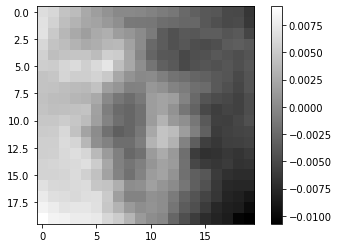

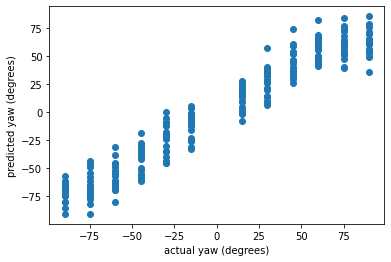

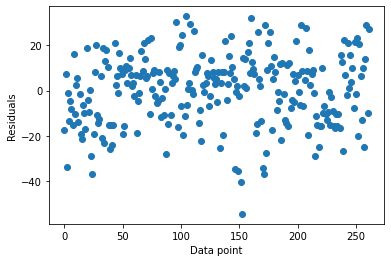

In [6]:
pitch_value = 0
lam = 10000000  #10000000 was starting point
X_restricted = X_train[pitches_train == pitch_value, :]
w = np.linalg.inv(X_restricted.T.dot(X_restricted) + lam*np.eye(X.shape[1])).dot(X_restricted.T.dot(yaws_train[pitches_train == pitch_value]))

# Plot weights
plt.imshow(w[:-1].reshape((20, 20)))
plt.colorbar()
plt.show()

# Plot Predicted and Actual yaw
plt.scatter(yaws_train[pitches_train == pitch_value], X_restricted.dot(w))
plt.xlabel('actual yaw (degrees)')
plt.ylabel('predicted yaw (degrees)')
plt.show()

# Plot residuals
plt.scatter(np.arange(len(yaws_train[pitches_train == pitch_value])),X_restricted.dot(w)-yaws_train[pitches_train == pitch_value])
plt.xlabel('Data point')
plt.ylabel('Residuals')
plt.show()

## Plotting pixels
Sometimes when working with image data, it can be a little tricky to visualize. Above, we looked at the plots of our weights. Here, we'll look at two plots, where each plot shows the value of two different pixels. Each dot represents a different face image. In the top plot, we randomly picked two pixel (feel free to change the numbers). In the second plot, we selected the pixels based on their weights.

**Discuss: Why does the second plot show more distinct differences?**



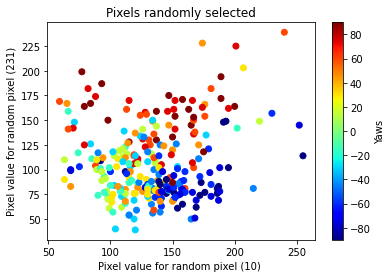

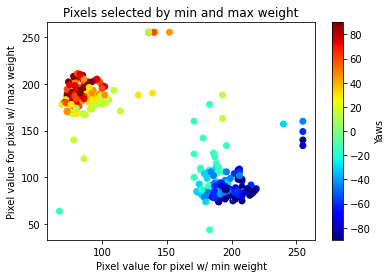

In [7]:
idx_w_max= np.where(w==np.max(w))
#print(idx_w_max, ' idx for ', w[idx_w_max])
idx_w_min = np.where(w==np.min(w))
#print(idx_w_min, ' idx for ', w[idx_w_min])

plt.scatter(X_restricted[:,10],X_restricted[:,231],c=yaws_train[pitches_train == pitch_value],cmap="jet")
plt.title('Pixels randomly selected')
plt.xlabel('Pixel value for random pixel (10) ')
plt.ylabel('Pixel value for random pixel (231)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Yaws')
plt.show()

#ax2 = fig.add_subplot(133,aspect='equal')
plt.scatter(X_restricted[:,idx_w_min],X_restricted[:,idx_w_max],c=yaws_train[pitches_train == pitch_value],cmap="jet")
plt.title('Pixels selected by min and max weight')
plt.xlabel('Pixel value for pixel w/ min weight')
plt.ylabel('Pixel value for pixel w/ max weight')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Yaws')
plt.show()

## Consider the model and data

Now that you've had a chance to work with these data, refer back to the [original dataset](https://web.archive.org/web/20190716041053/http://www-prima.inrialpes.fr/perso/Gourier/Faces/HPDatabase.html) and data collection protocol. Check out the photos of their setup. 

**Discuss: What are some of the limitations of this data set and/or the linear regression model?**


If you have not seen it previously, you may also want to check out the [Gender Shades Project](http://gendershades.org/overview.html). 


# Motivating logistic regression


You may have noticed in the plot above that the yaws appeared to fall into two groups: looking to the left or looking to the right (i.e., clusters of similar colors).

Now, we will explore the same data from a binary classification framing and apply linear regression. For binary classification, we'll need to consolidate our output from a range of yaw values to a binary set of outputs (bin_yaws_train).


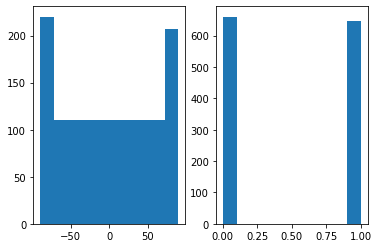

In [8]:
# Make new outputs with binary 1 for positive yaws, 0 for negative
bin_yaws_train = np.zeros_like(yaws_train)
bin_yaws_train[yaws_train>0] = 1
bin_yaws_test = np.zeros_like(yaws_test)
bin_yaws_test[yaws_test>0] = 1

#histograms to confirm that the outputs are now binary
plt.subplot(1,2,1)
plt.hist(yaws_train)
plt.subplot(1,2,2)
plt.hist(bin_yaws_train)
plt.show()

##Run logistic regression
Now let's run logistic regression on our binary outputs. 

Study the code and plots below to understand what is happening. 

Then manipulate C, which is the inverse of the regularization strength. 

**Discuss: What happens to the plots and accuracy as you manipulate C?**


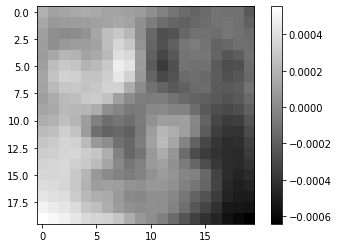

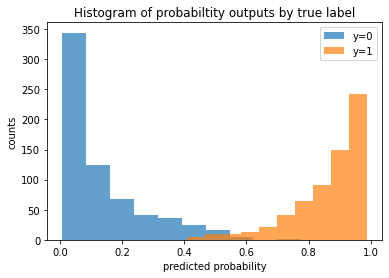

Accuracy on training set 0.9808722264728386
Accuracy on testing set 1.0


In [9]:
from sklearn.linear_model import LogisticRegression

def fit_model(X_input,y_input):
    model = LogisticRegression(max_iter=10000,C=0.0000001) #starts at C=0.0000001
    model.fit(X_input, y_input)
    return model

model = fit_model(X_train,bin_yaws_train);
pred_bin_yaws_train = model.predict(X_train) #This gives a prediction as a binary
prob_bin_yaws_train = model.predict_proba(X_train) #This gives the probability of each output (0,1)

# Plot weights
mc = np.squeeze(model.coef_)
plt.imshow(mc[:-1].reshape((20, 20)))
plt.colorbar()
plt.show()

#Plot histogram of outputs
plt.figure()
plt.hist(prob_bin_yaws_train[bin_yaws_train==0,1],alpha=0.7)
plt.hist(prob_bin_yaws_train[bin_yaws_train==1,1],alpha=0.7)
plt.legend(['y=0','y=1'])
plt.xlabel('predicted probability')
plt.ylabel('counts')
plt.title('Histogram of probabiltity outputs by true label')
plt.show()


print('Accuracy on training set', (pred_bin_yaws_train == bin_yaws_train).mean())
print('Accuracy on testing set', (model.predict(X_test) == bin_yaws_test).mean())


Finally, we'll plot the values from a couple of pixels again with the colors based on our binary categories. The pixels to plot are based on the most extreme weights from the linear and logistic regression models.

**Discuss: What do you observe about these plots? What happens when C=0.0000001 vs something else? What does this suggest?**

(array([380]),)  idx for  [0.00055437]
(array([399]),)  idx for  [-0.00064214]


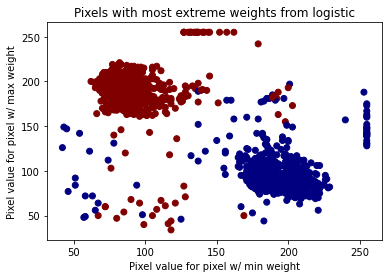

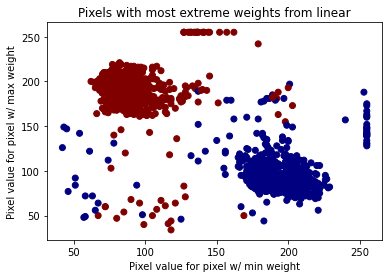

In [10]:
idx_mc_max= np.where(mc==np.max(mc))
print(idx_mc_max, ' idx for ', mc[idx_mc_max])
idx_mc_min = np.where(mc==np.min(mc))
print(idx_mc_min, ' idx for ', mc[idx_mc_min])

plt.scatter(X_train[:,idx_mc_min],X_train[:,idx_mc_max],c =bin_yaws_train ,cmap="jet")
plt.xlabel('Pixel value for pixel w/ min weight')
plt.ylabel('Pixel value for pixel w/ max weight')
plt.title('Pixels with most extreme weights from logistic')
plt.show()

plt.scatter(X_train[:,idx_w_min],X_train[:,idx_w_max],c =bin_yaws_train ,cmap="jet")
plt.xlabel('Pixel value for pixel w/ min weight')
plt.ylabel('Pixel value for pixel w/ max weight')
plt.title('Pixels with most extreme weights from linear')
plt.show()



That's all for this notebook. Optionally, you can go back and do the same analysis but splitting into a binary classification of looking ahead vs looking to the side (threshold at around 45 degrees). Or you can just move on to the assignment.




##Remember to do your reflection on Canvas!